### Setting generator

In [157]:
import pycbc.waveform.generator
import bilby
import numpy as np

time_event = bilby.gw.utils.get_event_time("GW170817")
detectors = ["H1", "L1", "V1"]

var_params = ["mass1", "mass2", "lambda1", "lambda2"]
frozen_params = dict(approximant="IMRPhenomPv2_NRTidal",
                     tc=time_event,
                     ra=197.45*np.pi/180,
                     dec=-23.3814*np.pi/180,
                     polarization=0, # TODO: check right value
                     distance=40.,
                     spin1z=0.02,
                     spin2z=0.02,
                     f_lower=100.,
                     f_ref=120.,
                     f_final=1024.,
                     delta_f=1./100.)

radiation_frame_generator = pycbc.waveform.generator.FDomainCBCGenerator
detector_frame_generator = pycbc.waveform.generator.FDomainDetFrameGenerator(
    rFrameGeneratorClass=radiation_frame_generator, epoch=0,
    detectors=detectors, variable_args=var_params, **frozen_params)

### Generate waveforms

In [158]:
n_samples = 10
concatenated_inputs_to_flow = []
params = []

for i in range(n_samples):

    # Uniform priors
    mass1 = np.random.uniform(1.36, 1.7)
    mass2 = np.random.uniform(1.17, 1.36)
    lambda1 = np.random.uniform(0,1500)
    lambda2 = np.random.uniform(0,1500)

    # Generation
    waveforms = detector_frame_generator.generate(
        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2)

    # Compressing
    """
    low_freqs = np.linspace(20, 400, 5000)
    high_freqs = np.linspace(400, 1024, 1000)
    freqs = np.concatenate((low_freqs, high_freqs))
    strain_H1_compressed = pycbc.waveform.compress.compress_waveform(
        waveforms["H1"], freqs, interpolation="nearest",
        precision="single", tolerance=1)
    """
    compression_freqs_H1 = pycbc.waveform.compress.spa_compression(
        waveforms["H1"], 20, 1024, 
        sample_frequencies=waveforms["H1"].sample_frequencies)

    

    # Alternative solution : cropping
    strain_H1 = waveforms["H1"][3000:4000]
    strain_L1 = waveforms["L1"][3000:4000]
    strain_V1 = waveforms["V1"][3000:4000]
    
    real_strain_H1 = strain_H1.real()
    real_strain_L1 = strain_L1.real()
    real_strain_V1 = strain_V1.real()

    imag_strain_H1 = strain_H1.imag()
    imag_strain_L1 = strain_L1.imag()
    imag_strain_V1 = strain_V1.imag()

    # Storing
    params.append({"mass_1":mass1/1.7, "mass_2":mass2/1.36,
        "lambda_1":lambda1/1500, "lambda_2":lambda2/1500})
    concatenated_inputs_to_flow.append(np.concatenate(
        (real_strain_H1, real_strain_L1, real_strain_V1,
         imag_strain_H1, imag_strain_L1, imag_strain_V1), axis=0))

    print("\rProgress: {:.0f}%".format(i/n_samples*100),
                    end="", flush=True)
print("\rStrains generated.")

Strains generated.


### Saving

In [17]:
import h5py

def save(list_of_concatenated_strains, list_of_associated_params, path):
        with h5py.File(path, 'a') as file:
            n_samples = len(list_of_concatenated_strains)
            for i in range(n_samples):
                concatenated_strains = list_of_concatenated_strains[i]
                params = list_of_associated_params[i]
                dataset = file.create_dataset(f"merger_BNS_{i}",
                    data=concatenated_strains)
                dataset.attrs["mass_1"] = float(params["mass_1"])
                dataset.attrs["mass_2"] = float(params["mass_2"])
                dataset.attrs["lambda_1"] = float(params["lambda_1"])
                dataset.attrs["lambda_2"] = float(params["lambda_2"])
                print("\rSaving files {:.0f}%".format(i/n_samples*100),
                    end="", flush=True)
            print("\rAll files saved.\n")


path = "data/"

save(concatenated_inputs_to_flow, params,
path + "trainset_freq_projected_nonoise.hdf")

All files saved.



#### Plotting

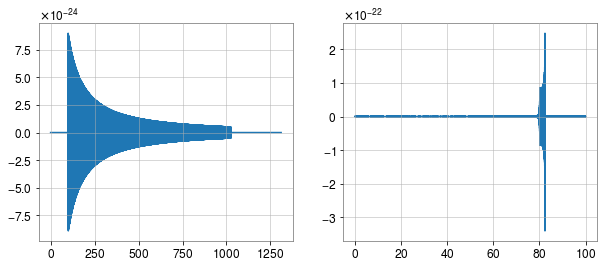

In [159]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
tstrain = waveforms["H1"].to_timeseries()
ax1.plot(waveforms["H1"].sample_frequencies, waveforms["H1"])
ax2.plot(tstrain.sample_times, tstrain)

(6000,)

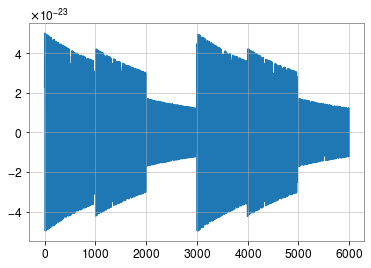

In [5]:
plt.plot(concatenated_inputs_to_flow[0])
concatenated_inputs_to_flow[0].shape

[Text(0, 0.5, 'Phase'), Text(0.5, 0, 'Frequency [Hz]')]

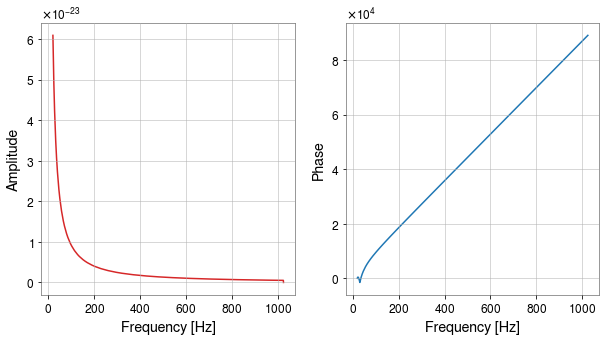

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(strain_H1_compressed.sample_points, strain_H1_compressed.amplitude, c="tab:red")
ax2.plot(strain_H1_compressed.sample_points, strain_H1_compressed.phase)
ax1.set(xlabel="Frequency [Hz]", ylabel="Amplitude")
ax2.set(xlabel="Frequency [Hz]", ylabel="Phase")

In [167]:
compression_freqs = pycbc.waveform.compress.spa_compression(waveforms["H1"], 60, 1024, sample_frequencies=waveforms["H1"].sample_frequencies)

strain_H1_compressed = pycbc.waveform.compress.compress_waveform(
        waveforms["H1"], compression_freqs, interpolation="nearest",
        precision="single", tolerance=1)

array([  60.  ,   60.05,   60.1 , ..., 1023.9 , 1023.95,
       1024.  ])

19281

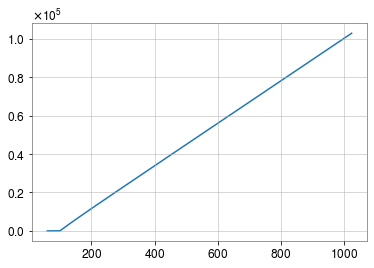

In [172]:
plt.plot(strain_H1_compressed.sample_points, strain_H1_compressed.phase)
len(compression_freqs)

In [323]:
"""
low_freq = np.linspace(40, 200, 320)
mid_freq = np.linspace(200, 500, 1001)
high_freq = np.linspace(500, 1024, 2681)
freq_array = np.concatenate((low_freq, mid_freq[1:], high_freq[1:]))
"""

# Compression of the waveform
freq_array = np.linspace(30, 1024, 1500)
sample_points = pycbc.types.array.Array(freq_array)
df = sample_points[1] - sample_points[0]

# Projection parameters
time_event = bilby.gw.utils.get_event_time("GW170817")
ra = 197.45*np.pi/180
dec = -23.3814*np.pi/180
polarization = 0

concatenated_strains = []
params = []
n_samples = 100

for i in range(n_samples):

    # Uniform priors
    mass1 = np.random.uniform(1.36, 1.7)
    mass2 = np.random.uniform(1.17, 1.36)
    lambda1 = np.random.uniform(0,1500)
    lambda2 = np.random.uniform(0,1500)

    dict_params = dict(approximant="IMRPhenomPv2_NRTidal",
                       tc=time_event,
                       distance=40.,
                       spin1z=0.02,
                       spin2z=0.02,
                       f_ref=50.,
                       sample_points=sample_points,
                       mass1=mass1,
                       mass2=mass2,
                       lambda1=lambda1,
                       lambda2=lambda2)

    hp, hc = pycbc.waveform.waveform.get_fd_waveform_sequence(**dict_params)

    hp = pycbc.types.frequencyseries.FrequencySeries(hp, delta_f=df).to_timeseries()
    hc = pycbc.types.frequencyseries.FrequencySeries(hc, delta_f=df).to_timeseries()

    det_h1 = pycbc.detector.Detector('H1')
    det_l1 = pycbc.detector.Detector('L1')
    det_v1 = pycbc.detector.Detector('V1')

    signal_h1 = det_h1.project_wave(hp, hc, ra, dec, polarization).to_frequencyseries()
    signal_l1 = det_l1.project_wave(hp, hc, ra, dec, polarization).to_frequencyseries()
    signal_v1 = det_v1.project_wave(hp, hc, ra, dec, polarization).to_frequencyseries()

    real_h1 = signal_h1.real()
    real_l1 = signal_l1.real()
    real_v1 = signal_v1.real()

    imag_h1 = signal_h1.imag()
    imag_l1 = signal_l1.imag()
    imag_v1 = signal_v1.imag()

    # Storing
    params.append({"mass_1":mass1/1.7, "mass_2":mass2/1.36,
        "lambda_1":lambda1/1500, "lambda_2":lambda2/1500})
    concatenated_strains.append(
        np.concatenate((real_h1, real_l1, real_v1, imag_h1, imag_l1, imag_v1), axis=0))
    
    print("\rProgress: {:.0f}%".format(i/n_samples*100),
                    end="", flush=True)
print("\rStrains generated.")

Strains generated.


In [213]:
np.linspace(40, 1024, 10000)[1] - np.linspace(40, 1024, 10000)[0]

0.09840984098409677

In [287]:
plt.plot(hp.sample_frequencies, hp)
fseries.sample_frequencies.shape

AttributeError: 'TimeSeries' object has no attribute 'sample_frequencies'

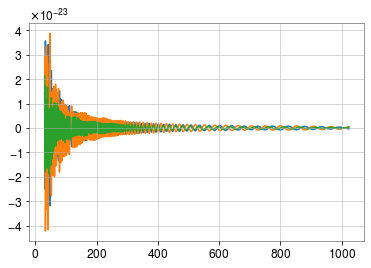

In [324]:
plt.plot(signal_h1.sample_frequencies+30, signal_h1)
plt.plot(signal_l1.sample_frequencies+30, signal_l1)
plt.plot(signal_v1.sample_frequencies+30, signal_v1)

9198

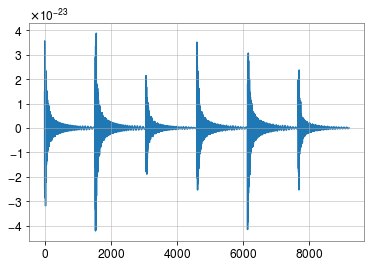

In [326]:
plt.plot(concatenated_strains[99])
len(concatenated_strains[0])